In [2]:
from glob import glob
import json
import os

import numpy as np
import pandas as pd

from plotnine import *

from dataclasses import dataclass
from collections import defaultdict
from typing import Dict, List, Set

# Import and parse GISAID summary data from COVID-CG

In [12]:
covid_cg_snvs1 = "/Users/rosekantor/data/wbe_scv/variant_info/consensus_mutations_covidcg_1perc_101821.json"
var1_df = pd.read_json(covid_cg_snvs1)
var1_df = var1_df.rename(columns={'pos':'position', 'name':'variant'})

In [51]:
# manually define lineages based on most current CDC definitions:
# https://www.cdc.gov/coronavirus/2019-ncov/variants/variant-info.html

alpha = var1_df[var1_df.variant.str.startswith('Q')].variant.unique().tolist()
alpha.append('XA')
alpha.append('B.1.1.7')

beta = ['B.1.351', 'B.1.351.2', 'B.1.351.3']

gamma = var1_df[var1_df.variant.str.startswith('P.1.')].variant.unique().tolist()
gamma.append('P.1')

delta = var1_df[var1_df.variant.str.startswith('AY')].variant.unique().tolist()
delta.append('B.1.617.2')

epsilon = ['B.1.427', 'B.1.429']
eta = ['B.1.525']
iota = ['B.1.526']
kappa = ['B.1.617.1']
unnamed = ['B.1.617.3']
mu = ['B.1.621', 'B.1.621.1']
zeta = ['P.2']

variants = {'alpha':alpha, 'beta':beta, 'gamma':gamma, 'delta':delta,
            'epsilon':epsilon, 'eta':eta, 'iota':iota, 'kappa':kappa,
            'unnamed':unnamed, 'mu':mu, 'zeta':zeta}

## get unique SNVs for VoCs

In [52]:
variants_df = []
for v in variants.keys():
    lineages = variants[v]
    
    # define set of snvs found in the lineage(s) of interest at > 90%
    snvs_in = set(var1_df[(var1_df.fraction > 0.90) &
                      (var1_df.variant.isin(lineages))].snv_name)

    # define set of snvs found in all other lineages at > 50%
    snvs_out = set(var1_df[(var1_df.fraction > 0.50) &
                  (~var1_df.variant.isin(lineages))].snv_name)
    
    # remove > 50% other lineage snvs from the snv set for lineages of interest
    snvs_signature = snvs_in - snvs_out
    snvs_df = var1_df[(var1_df.snv_name.isin(snvs_signature)) & (var1_df.variant.isin(lineages))].copy()
    snvs_df['voc_name'] = v
    
    # drop duplicates if snv appears in multiple sublineages, we still only need one row for it
    snvs_df = snvs_df.drop(columns=['variant', 'fraction', 'count'])
    snvs_df = snvs_df.drop_duplicates()
    variants_df.append(snvs_df)
    
variants_df = pd.concat(variants_df)

In [53]:
variants_df

,snv_id,position,ref,alt,snv_name,voc_name
9103,15472,16176,T,C,T16176C,alpha
9109,37392,23271,C,A,C23271A,alpha
9116,54384,28095,A,T,A28095T,alpha
9117,54453,28111,A,G,A28111G,alpha
9128,71238,5388,C,A,C5388A,alpha
...,...,...,...,...,...,...
19654,47504,26492,A,T,A26492T,mu
19667,19453,17707,C,T,C17707T,mu
32065,7809,13057,A,T,A13057T,mu
32077,64914,3428,A,G,A3428G,mu


# Import sample data

In [54]:
def load_samples(path: str) -> pd.DataFrame:
    samples = []
    for f in glob(f'{path}/*.tsv'):
        s = os.path.basename(f).split('.')[0]
        df = pd.read_csv(f, sep='\t')
        df['sample_id'] = s
        samples.append(df)
    samples = pd.concat(samples)
    samples = samples.rename(columns={'POS':'position', 'REF':'ref', 'ALT':'alt'})
    samples = samples[['position', 'ref', 'alt', 'REF_DP', 'ALT_DP', 'ALT_FREQ', 'TOTAL_DP', 'PVAL', 'PASS', 'sample_id']]
    samples['snv_name'] = samples.ref + samples.position.astype('str') + samples.alt
    
    return samples


def samples_to_dict(samples, ivar_pass=True, min_depth=10, min_alt=5, min_freq=0.05):
    # use different options to require more/less certainty about SNVs)
    samples = samples[samples.PASS == ivar_pass]
    samples = samples[samples.TOTAL_DP >= min_depth]
    samples = samples[samples.ALT_DP >= min_alt]
    samples = samples[samples.ALT_FREQ > min_freq]

    # make dictionary of samples-to-snvs
    sample_snvs: Dict[str, Set[str]] = defaultdict(set)
    for s, df in samples.groupby("sample_id"):
        sample_snvs[s].update(df["snv_name"])
        
    return sample_snvs

## Import sample stats

In [55]:
# data directories
datadir1 = '/Users/rosekantor/data/wbe_scv/qb3_march2021/artic'
datadir2 = '/Users/rosekantor/data/wbe_scv/qb3_may2021'
datadir3 = '/Users/rosekantor/data/wbe_scv/qb3_artic_052621'
datadir4 = '/Users/rosekantor/data/wbe_scv/qb3_artic_062921'
datadir5 = '/Users/rosekantor/data/wbe_scv/qb3_artic_073021'
datadir6 = '/Users/rosekantor/data/wbe_scv/qb3_artic_080721'

dirs = [datadir1, datadir2, datadir3, datadir4, datadir5, datadir6]

# import precompiled stats (from sequencing_stats.ipynb)
stats_df = pd.read_csv('/Users/rosekantor/data/wbe_scv/sequencing_stats_thru_Aug2021.csv')

In [56]:
sample_counts = stats_df.groupby('sample_code').agg(counts=('sample_id', 'count')).reset_index()
multiple_samples = sample_counts[sample_counts.counts > 4].sample_code.to_list()

## Import variant-calling

In [57]:
# load iVar results for samples and parse
samples1 = load_samples('/Users/rosekantor/data/wbe_scv/qb3_march2021/artic/variants_ivar/')
samples2 = load_samples('/Users/rosekantor/data/wbe_scv/qb3_may2021/variants_ivar/')
samples3 = load_samples('/Users/rosekantor/data/wbe_scv/qb3_artic_052621/variants_ivar/')
samples4 = load_samples('/Users/rosekantor/data/wbe_scv/qb3_artic_062921/variants_ivar/')
samples5 = load_samples('/Users/rosekantor/data/wbe_scv/qb3_artic_073021/variants_ivar/')
samples6 = load_samples('/Users/rosekantor/data/wbe_scv/qb3_artic_080721/variants_ivar/')
samples_variants = pd.concat([samples1, samples2, samples3, samples4, samples5, samples6])

# convert iVar sample results to dict
# sample_snvs = samples_to_dict(samples_variants)


In [58]:
# filter samples
ivar_pass=True
min_depth=10
min_alt=10
min_freq=0.05

# use different options to require more/less certainty about SNVs)
samples_filt = samples_variants[samples_variants.PASS == ivar_pass]
samples_filt = samples_filt[samples_filt.TOTAL_DP >= min_depth].copy()
samples_filt = samples_filt[samples_filt.ALT_DP >= min_alt].copy()
samples_filt = samples_filt[samples_filt.ALT_FREQ > min_freq].copy()

## Import depth

In [59]:
# read in all depth files and combine into df
depth_df = []
for batch in range(0,len(dirs)):
    for f in glob(f'{dirs[batch]}/depth/*depth.txt'):
        s = os.path.basename(f).split('.')[0]
        df = pd.read_csv(f, sep='\t', names=['ref', 'position', 'coverage'])
        df['sample_id'] = s
        depth_df.append(df)
depth_df = pd.concat(depth_df)

# For each sample, determine presence of unique SNVs

In [60]:
# filter depth for all locations of VOC snvs with coverage > 10x and merge with VOC info
vocs_x_depth = depth_df[(depth_df.coverage >= 10) &
                        (depth_df.position.isin(variants_df.position))]
vocs_x_depth = vocs_x_depth.drop(columns = 'ref')
vocs_x_depth = vocs_x_depth.merge(variants_df, how = 'left', on='position')

In [61]:
# merge voc and depth info with variant calling
vocs_x_samples = vocs_x_depth.merge(samples_filt, how='left', on=['sample_id', 'snv_name', 'position', 'alt', 'ref'])

# merge with stats on the samples
vocs_x_samples = vocs_x_samples.merge(stats_df, how='left', on='sample_id')

vocs_x_samples.coverage = pd.to_numeric(vocs_x_samples.coverage)

# summarize by aggregating frequencies across all replicates and all SNVs within the same VoC
voc_summary = vocs_x_samples.groupby(['site_full_name', 'sample_code', 'date_sampling', 'voc_name']).agg(avg_freq=('ALT_FREQ', 'mean'),
                                                                                       coverage_mean=('coverage', 'mean'),
                                                                                       snvs_count=('snv_name', 'count')).reset_index()

# convert dtypes appropriately
voc_summary.voc_name = pd.Categorical(voc_summary.voc_name)
voc_summary.date_sampling = pd.to_datetime(voc_summary.date_sampling)
voc_summary.site_full_name = pd.Categorical(voc_summary.site_full_name, categories=voc_summary.site_full_name.unique().tolist()[::-1], ordered=True)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


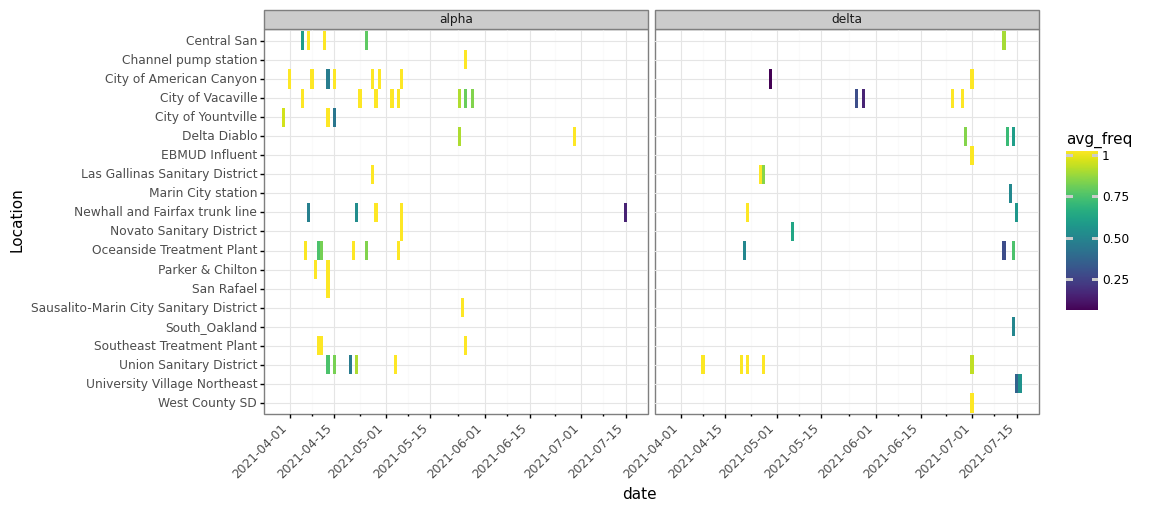

<ggplot: (392743602)>

In [62]:
alpha_delta_summary = voc_summary[voc_summary.voc_name.isin(['alpha', 'delta'])].dropna().copy()

# show dates scaled to time
(ggplot(alpha_delta_summary, aes(x='date_sampling', y='site_full_name', fill='avg_freq'))+
 geom_tile()+
 theme_bw()+
 theme(axis_text_x=element_text(angle=45, hjust=1),
      figure_size=(10,5))+
 ylab('Location')+
 xlab('date')+
 facet_wrap('~ voc_name')
)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


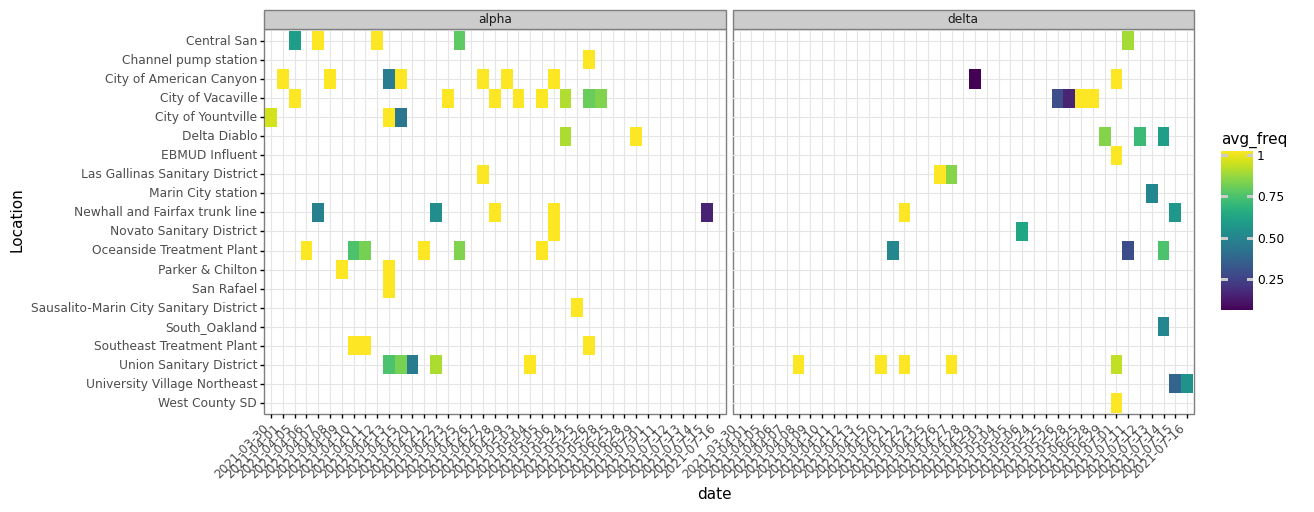

<ggplot: (392145228)>

In [63]:
# show the dates as columns, not scaled to time
alpha_delta_summary = voc_summary[voc_summary.voc_name.isin(['alpha', 'delta'])].dropna().copy()
alpha_delta_summary.date_sampling = alpha_delta_summary.date_sampling.astype('str')
(ggplot(alpha_delta_summary, aes(x='date_sampling', y='site_full_name', fill='avg_freq'))+
 geom_tile()+
 theme_bw()+
 theme(axis_text_x=element_text(angle=45, hjust=1),
      figure_size=(12,5))+
 ylab('Location')+
 xlab('date')+
 facet_wrap('~ voc_name')
)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 70 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 30 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


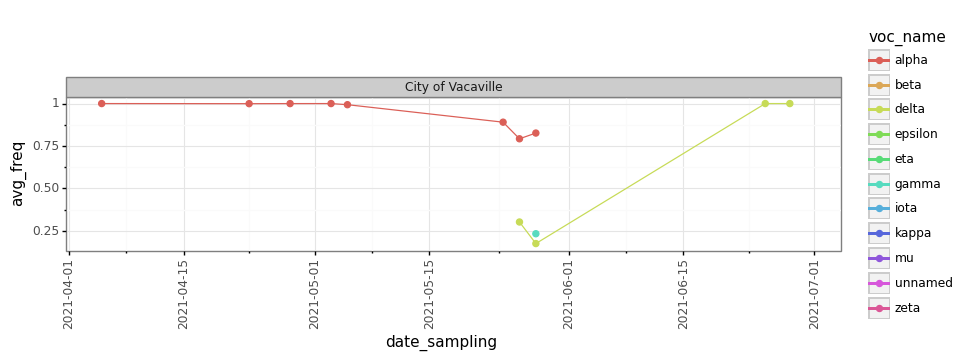

<ggplot: (380312197)>

In [64]:
(ggplot(voc_summary[voc_summary.sample_code == 'S_S_INF'], aes(x='date_sampling', y='avg_freq', color='voc_name'))+
 geom_point(size=2)+
 geom_line(aes(x='date_sampling', y='avg_freq', color='voc_name'))+
 facet_wrap('~ site_full_name', ncol=2)+
 theme_bw()+
 theme(figure_size=(10,2), axis_text_x=element_text(angle=90, hjust=1.1))
) 

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 61 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 47 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


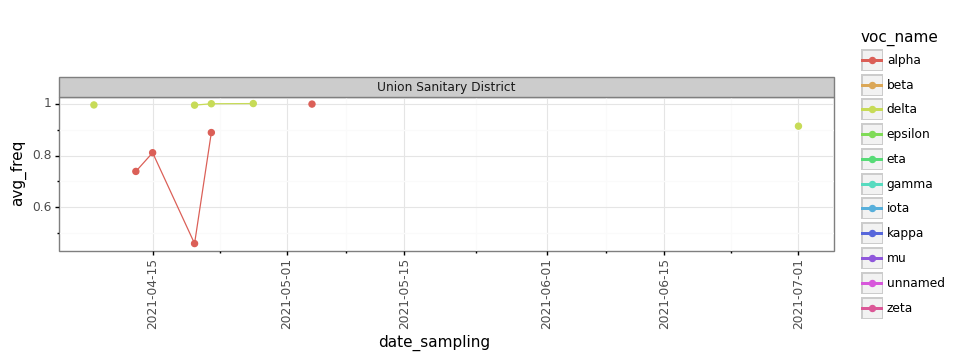

<ggplot: (681043020)>

In [65]:
(ggplot(voc_summary[voc_summary.sample_code == 'R_R_Alvarado'], aes(x='date_sampling', y='avg_freq', color='voc_name'))+
 geom_point(size=2)+
 geom_line(aes(x='date_sampling', y='avg_freq', color='voc_name'))+
 facet_wrap('~ site_full_name', ncol=2)+
 theme_bw()+
 theme(figure_size=(10,2), axis_text_x=element_text(angle=90, hjust=1.1))
) 

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 124 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


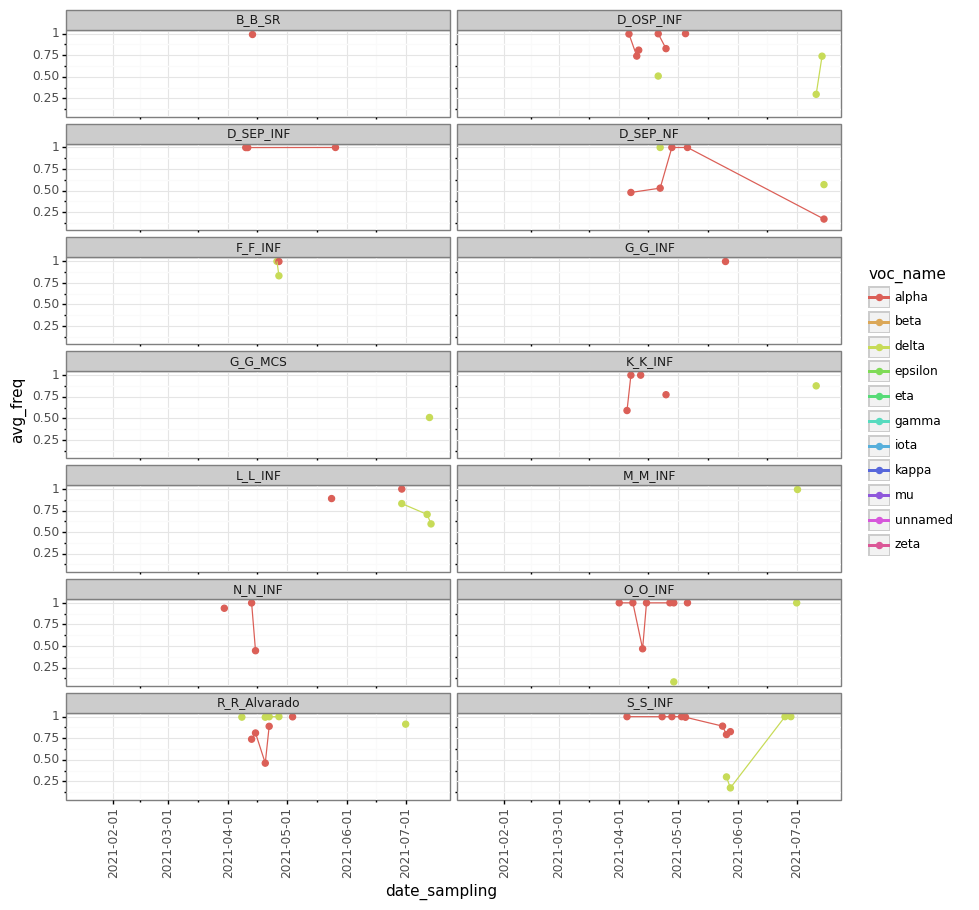

<ggplot: (384506498)>

In [43]:
# ['B_B_SR', 'D_OSP_INF', 'D_SEP_INF', 'D_SEP_NF', 'F_F_INF', 'G_G_INF',
#        'G_G_MCS', 'I_I_INF', 'J_J_Park', 'K_K_INF', 'L_L_INF', 'M_M_INF',
#        'N_N_INF', 'O_O_INF', 'R_R_Alvarado', 'S_S_INF']

voc_summary_filt = voc_summary[(voc_summary.sample_code.isin(multiple_samples)) &
                               (voc_summary.voc_name.isin(['alpha', 'delta']))].copy()

# voc_summary_filt.voc_name = pd.Categorical(voc_summary_filt.voc_name, categories = ['alpha', 'delta'])

(ggplot(voc_summary_filt, aes(x='date_sampling', y='avg_freq', color='voc_name'))+
 geom_point(size=2)+
 geom_line(aes(x='date_sampling', y='avg_freq', color='voc_name'))+
 facet_wrap('~ sample_code', ncol=2)+
 theme_bw()+
 theme(figure_size=(10,10), axis_text_x=element_text(angle=90, hjust=1.1))
) 


In [82]:
# figure out if what is going on here still makes sense

# NOTE: not-detected doesn't make sense because the vocs 
# are groupings of multiple lineages so there will be some SNVs not detected

# summarize which variants were detected based on the SNVs that were called in each sample
summary = []
for [sample_id, voc_name], df in vocs_x_samples.groupby(['sample_id', 'voc_name']):
    # if coverage > 10 but ALT_FREQ is NA, then the variant was NOT detected
    # if ALT_FREQ > 10, then the variant was detected
    not_detected = len(df[(df.coverage > 10) & (df.ALT_FREQ.isna())])
    detected = len(df[~df.ALT_FREQ.isna()])
    avg_freq = df.ALT_FREQ.mean()
    
    summary.append([sample_id, voc_name, detected, not_detected, avg_freq])
    
summary = pd.DataFrame.from_records(summary, columns=['sample_id', 'voc_name', 'snvs_detected', 'not_detected', 'avg_freq'])

# collect just detected samples x variants
detected_df = summary[summary.snvs_detected > 0]

# merge with stats data so we can plot by date and location
detected_df = detected_df.merge(stats_df, how='left', on='sample_id')

In [83]:
detected_df

,sample_id,voc_name,snvs_detected,not_detected,avg_freq,original_id,fragment_analyzer_band,merge_id,batch,treatment,...,perc_mapped,perc_over_400x,perc_over_100x,perc_over_10x,perc_over_5x,spike_perc_over_400x,spike_perc_over_100x,spike_perc_over_10x,spike_perc_over_5x,site_full_name
0,B_B_SR_041321_1,alpha,2,11,0.996946,B_SR_041321_1,NaN,B_B_SR_041321_1,2,std,...,39.06,40.0,46.0,52.0,55.0,47.0,57.0,70.0,70.0,San Rafael
1,B_B_SR_042621_1,gamma,1,1,1.000000,B_B_SR_042621_1,NaN,B_B_SR_042621_1,3,std,...,4.39,2.0,3.0,8.0,10.0,0.0,8.0,15.0,15.0,San Rafael
2,C_C_INF_070121_4A,delta,1,4,0.995935,C_C_INF_070121_4,NaN,C_C_INF_070121_1,5,amicon,...,98.98,7.0,8.0,8.0,9.0,NaN,NaN,NaN,NaN,EBMUD Influent
3,C_C_S68_071421_1,delta,10,28,0.435383,C_C_S68_071421_1,NaN,C_C_S68_071421_1,6,std,...,99.96,50.0,60.0,68.0,70.0,43.0,44.0,53.0,53.0,South_Oakland
4,C_C_S68_071421_2,delta,8,29,0.592870,C_C_S68_071421_2,NaN,C_C_S68_071421_2,6,std,...,99.92,50.0,60.0,69.0,71.0,36.0,37.0,37.0,37.0,South_Oakland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,std_S_S_INF_052621_1,alpha,2,9,1.000000,std_S_S_INF_052621_1,NaN,S_S_INF_052621_1,4,std,...,97.72,28.0,36.0,44.0,48.0,22.0,33.0,55.0,55.0,City of Vacaville
119,std_S_S_INF_052621_1,delta,1,29,0.301508,std_S_S_INF_052621_1,NaN,S_S_INF_052621_1,4,std,...,97.72,28.0,36.0,44.0,48.0,22.0,33.0,55.0,55.0,City of Vacaville
120,std_S_S_INF_052821_1,alpha,5,13,0.809198,std_S_S_INF_052821_1,NaN,S_S_INF_052821_1,4,std,...,99.35,53.0,65.0,75.0,77.0,32.0,43.0,75.0,75.0,City of Vacaville
121,std_S_S_INF_052821_1,delta,1,39,0.174317,std_S_S_INF_052821_1,NaN,S_S_INF_052821_1,4,std,...,99.35,53.0,65.0,75.0,77.0,32.0,43.0,75.0,75.0,City of Vacaville


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 56 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


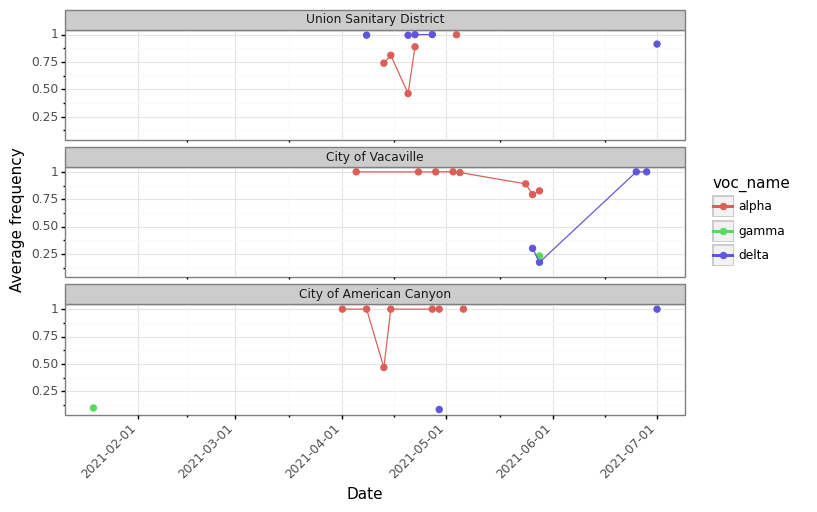

<ggplot: (377702614)>

In [66]:
# these 3 sites only contain alpha, gamma, and delta
voc_summary_filt = voc_summary[voc_summary.sample_code.isin(['S_S_INF', 'R_R_Alvarado', 'O_O_INF'])].copy()
voc_summary_filt = voc_summary_filt[voc_summary_filt.voc_name.isin(['alpha', 'gamma', 'delta'])]
voc_summary_filt.voc_name = pd.Categorical(voc_summary_filt.voc_name, categories=['alpha', 'gamma', 'delta'])
(ggplot(voc_summary_filt, aes(x='date_sampling', y='avg_freq', color='voc_name'))+
 geom_point(size=2)+
 geom_line()+
 facet_wrap('~ site_full_name', ncol=1)+
 theme_bw()+
 theme(figure_size=(8,5), axis_text_x=element_text(angle=45, hjust=1))+
 xlab('Date')+
 ylab('Average frequency')
) 

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


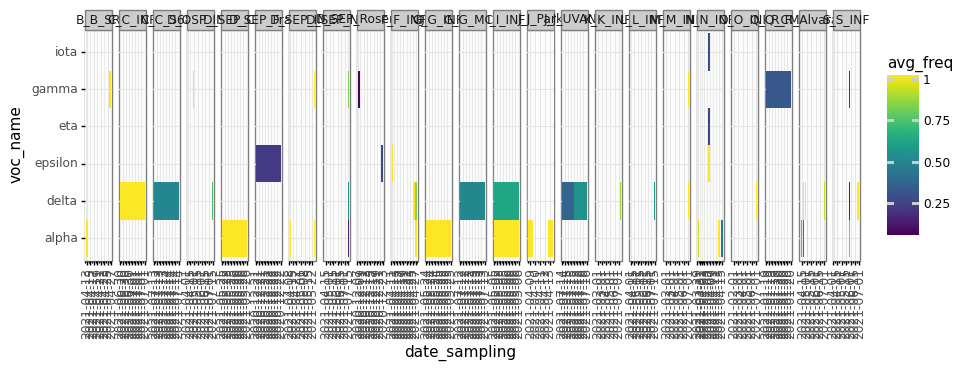

<ggplot: (378993140)>

In [70]:
voc_summary1 = voc_summary[~voc_summary.avg_freq.isna()].copy()
(ggplot(voc_summary1, aes(x='date_sampling', y='voc_name', fill='avg_freq'))+
 geom_tile()+
 facet_wrap('~ sample_code', scales='free_x', nrow=1)+
 theme_bw()+
 theme(figure_size=(10,3), axis_text_x=element_text(angle=90, hjust=1.1))
) 

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


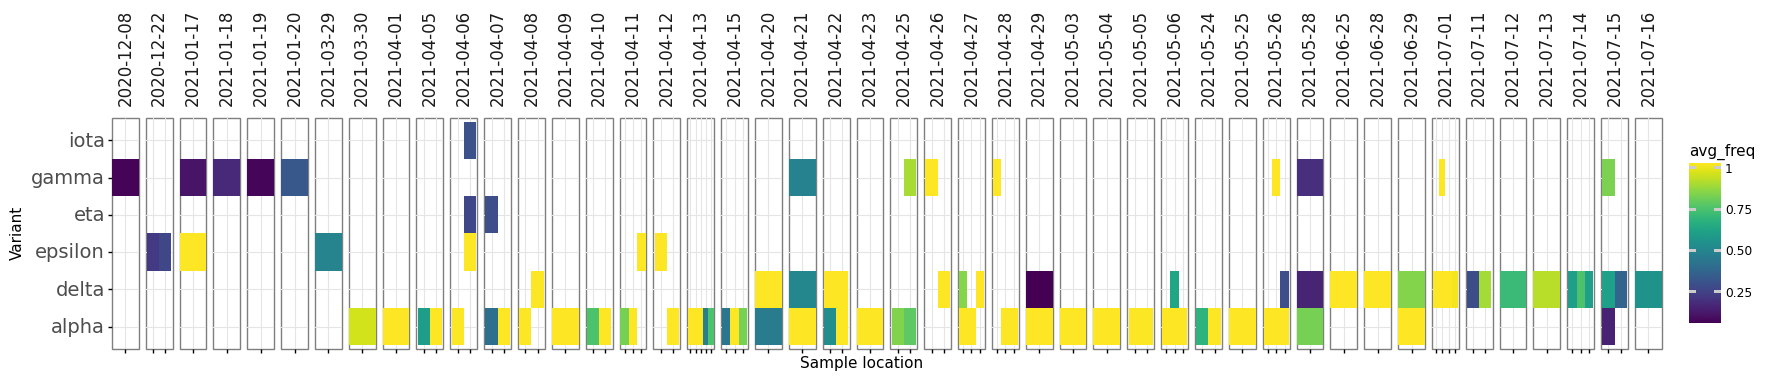

<ggplot: (681335655)>

In [100]:
voc_summary1 = voc_summary[~voc_summary.avg_freq.isna()].copy()
(ggplot(detected_df, aes(x='sample_code', y='voc_name', fill='avg_freq'))+
 geom_tile()+
 facet_wrap('~ date_sampling', scales='free_x', nrow=1)+
 theme_bw()+
 theme(figure_size=(20,3),
       #axis_text_x=element_text(angle=90, hjust=1.1),
       axis_text_x=element_blank(),
       strip_text_x=element_text(angle=90, va='bottom', size=12),
       strip_background=element_blank(),
       axis_text_y=element_text(size=14))+
 xlab('Sample location')+
 ylab('Variant')
) 

In [74]:
voc_summary1

,site_full_name,sample_code,date_sampling,voc_name,avg_freq,coverage_mean,snvs_count
23,California Medical Facility,Q_Q_CMF,2021-01-20,gamma,0.331707,2507.352941,17
34,Central San,K_K_INF,2021-01-18,gamma,0.150815,2740.500000,28
40,Central San,K_K_INF,2021-04-05,alpha,0.589997,125.700000,10
48,Central San,K_K_INF,2021-04-07,alpha,0.999407,1311.454545,11
59,Central San,K_K_INF,2021-04-11,epsilon,0.999828,7310.000000,1
...,...,...,...,...,...,...,...
851,University Village Northeast,J_J_UVANE,2021-07-16,delta,0.548796,3843.486486,37
861,West County SD,M_M_INF,2021-01-17,epsilon,0.999732,6117.333333,3
863,West County SD,M_M_INF,2021-01-17,gamma,0.130769,2973.733333,15
880,West County SD,M_M_INF,2021-07-01,delta,0.999780,5133.526316,38


In [78]:
voc_summary1 = voc_summary[~voc_summary.avg_freq.isna()].copy()
#voc_summary1['sample_name'] = voc_summary1['site_full_name'].astype('str') + voc_summary1['date_sampling'].astype('str')
(ggplot(voc_summary1, aes(x='sample_name', y='voc_name', fill='avg_freq'))+
 geom_tile()+
 facet_wrap('~ date_sampling', scales='free_x', nrow=1)+
 theme_bw()+
 theme(figure_size=(10,3), axis_text_x=element_text(angle=90, hjust=1.1))
) 

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


AttributeError: 'tuple' object has no attribute 'range'